In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
warnings.filterwarnings('ignore')

import warnings
import cmocean
from dask.distributed import Client

from xmitgcm import llcreader

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import ecco_v4_py as ecco

In [3]:
aste = llcreader.CRIOSPortalASTE270Model()

In [4]:
ds = aste.get_dataset()

In [5]:
ds = ds.sel(time='2014-12')

In [6]:
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [7]:
ncols=10
for i,f in enumerate(list(ds.data_vars),start=1):
    end = '\n' if i%ncols==0 else ', '
    print(f,end=end)

ADVr_SLT, ADVr_TH, ADVxHEFF, ADVxSNOW, ADVx_SLT, ADVx_TH, ADVyHEFF, ADVySNOW, ADVy_SLT, ADVy_TH
DETADT2, DFrE_SLT, DFrE_TH, DFrI_SLT, DFrI_TH, DFxEHEFF, DFxESNOW, DFxE_SLT, DFxE_TH, DFyEHEFF
DFyESNOW, DFyE_SLT, DFyE_TH, ETAN, ETANSQ, GM_PsiX, GM_PsiY, KPPg_SLT, KPPg_TH, MXLDEPTH
PHIBOT, SALT, SFLUX, SIaaflux, SIacSubl, SIarea, SIatmFW, SIatmQnt, SIheff, SIhsnow
SIsnPrcp, SItflux, SIuice, SIvice, SRELAX, TFLUX, THETA, TRELAX, UVELMASS, VVELMASS
WSLTMASS, WTHMASS, WVELMASS, oceFWflx, oceQnet, oceQsw, oceSPDep, oceSPflx, oceSPtnd, oceSflux
oceTAUX, oceTAUY, sIceLoad, 

In [8]:
ds.ADVx_TH

<xarray.DataArray 'ADVx_TH' (time: 1, k: 50, tile: 6, j: 270, i_g: 270)>
dask.array<getitem, shape=(1, 50, 6, 270, 270), dtype=float64, chunksize=(1, 1, 2, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 2014-12-01
Attributes:
    standard_name:  ADVx_TH
    long_name:      Zonal      Advective Flux of Pot.Temperature
    units:          degC.m^3/s
    mate:           ADVy_TH

In [9]:
tile1 = ds.ADVy_TH.where(ds.ADVy_TH.tile == 1, drop=True)
tile2 = ds.ADVy_TH.where(ds.ADVy_TH.tile == 2, drop=True)

tmp1 = tile1.values[0,:,0,:,:]
tmp2 = np.array([np.rot90(layer, 3) for layer in tile2.values[0,:,0,:,:]])

# stack these two
tmp3 = np.vstack((tmp1[0],tmp2[0]))

In [10]:
tile1 = ds.ADVx_TH.where(ds.ADVx_TH.tile == 1, drop=True)
tile2 = ds.ADVx_TH.where(ds.ADVx_TH.tile == 2, drop=True)

tmp4 = tile1.values[0,:,0,:,:]
tmp5 = np.array([np.rot90(layer, 3) for layer in tile2.values[0,:,0,:,:]])

# stack these two
tmp6 = np.vstack((tmp4[0],-tmp5[0]))

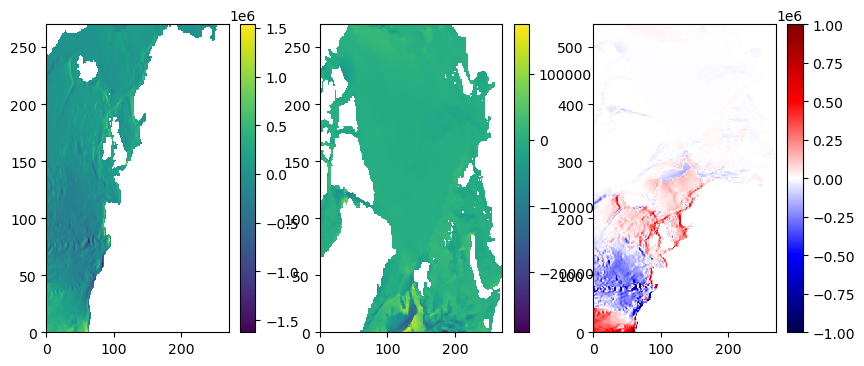

In [11]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tmp1[0])
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(tmp2[0])
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(tmp3,cmap = 'seismic',vmin=-1e6,vmax=1e6)
plt.colorbar(cb)

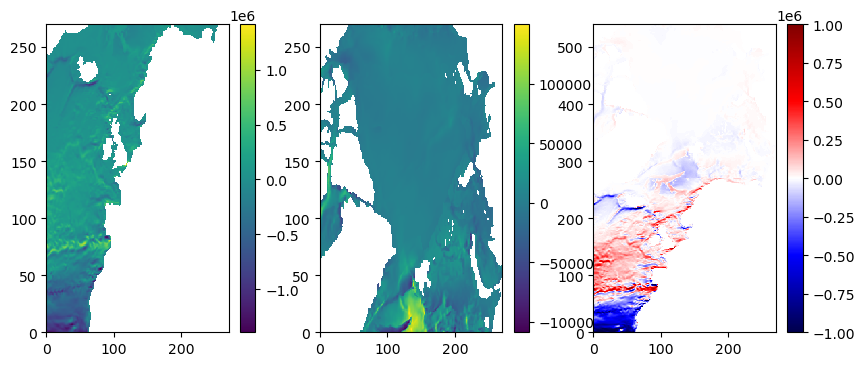

In [12]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tmp4[0])
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(tmp5[0])
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(tmp6,cmap = 'seismic',vmin=-1e6,vmax=1e6)
plt.colorbar(cb)

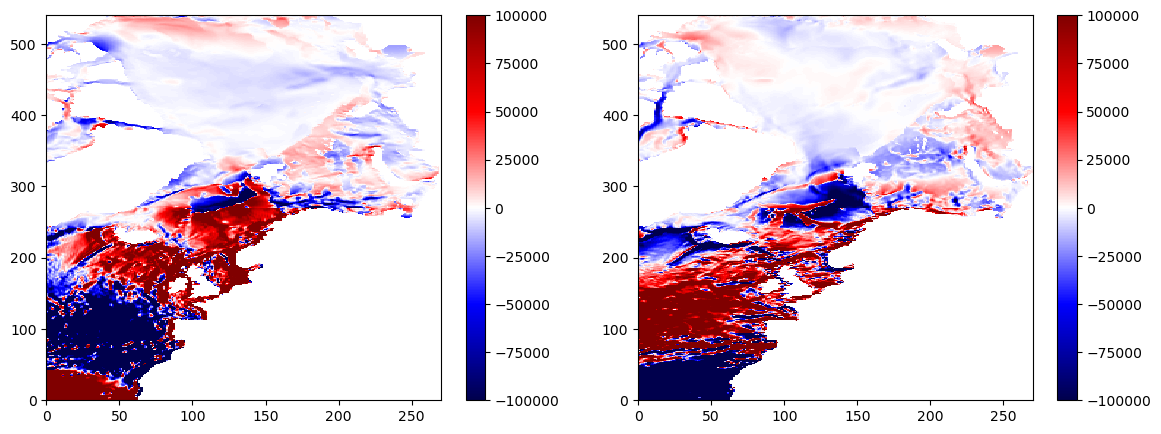

In [13]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot(121)
cb = ax.pcolormesh(tmp3,cmap = 'seismic',vmin=-1e5,vmax=1e5)
plt.colorbar(cb)

ax = plt.subplot(122)
cb = ax.pcolormesh(tmp6,cmap = 'seismic',vmin=-1e5,vmax=1e5)
plt.colorbar(cb)

In [14]:
# this is apparently not the correct way to stack the faces
testuvconv = calc_UV_conv_1face(tmp3,tmp6)

(250.0, 450.0)

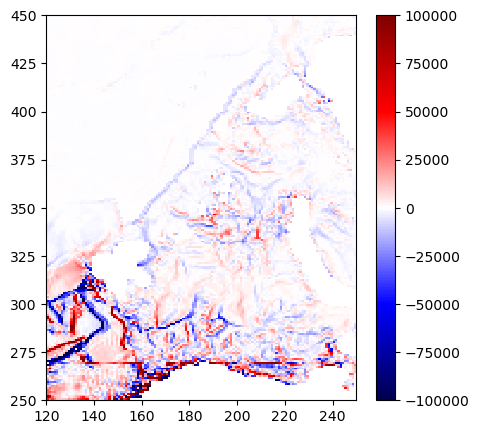

In [15]:
fig = plt.figure(figsize=(5,5))
plt.pcolormesh(testuvconv[0],vmin=-1e5,vmax=1e5,cmap='seismic')
plt.colorbar()
plt.xlim(120,250)
plt.ylim(250,450)

### Try with more fancy functions

In [16]:
grid = ecco.get_llc_grid(cds,domain='aste')
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'].sel(k=0),
                                                ds['VVELMASS'].sel(k=0),
                                                coords=cds,
                                                grid=grid)

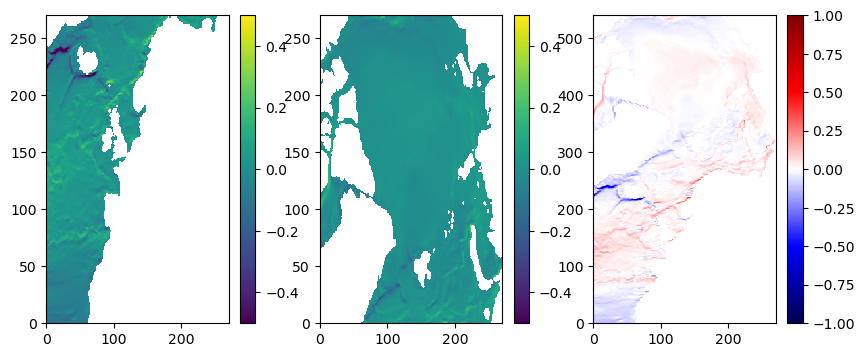

In [17]:
tile1 = uvel.where(uvel.tile == 1, drop=True)
tile2 = uvel.where(uvel.tile == 2, drop=True)


fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tile1.values[0,0,:,:],vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(tile2.values[0,0,:,:],3),vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)
a = np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3)))

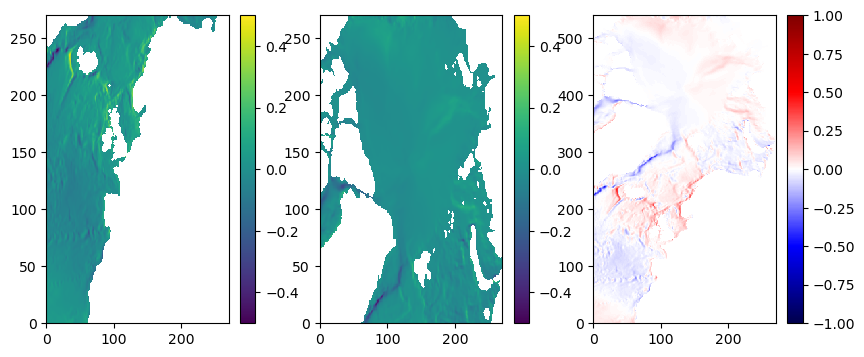

In [18]:
tile1 = vvel.where(uvel.tile == 1, drop=True)
tile2 = vvel.where(uvel.tile == 2, drop=True)


fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tile1.values[0,0,:,:],vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(tile2.values[0,0,:,:],3),vmin=-.5,vmax=.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3))),cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)
b = np.vstack((tile1.values[0,0,:,:],np.rot90(tile2.values[0,0,:,:],3)))

In [ ]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot(131)
cb = ax.pcolormesh(a,cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(b,cmap = 'seismic',vmin=-1,vmax=1)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(calc_UV_conv_1face(a,b)[0],cmap = 'seismic',vmin=-.1,vmax=.1)
plt.colorbar(cb)

(200.0, 300.0)

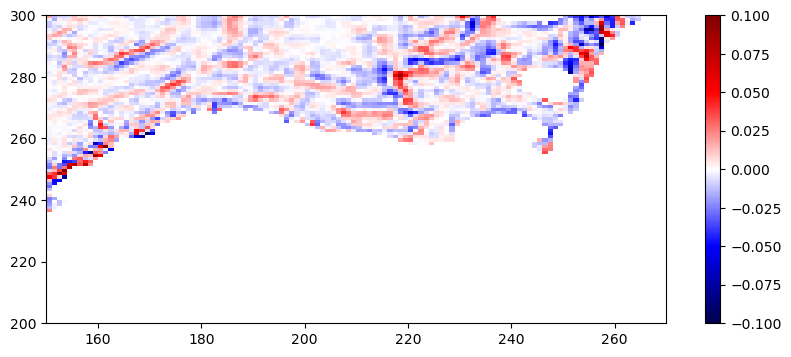

In [86]:
# double check this
fig = plt.figure()
ax = plt.subplot(111)
cb = ax.pcolormesh(calc_UV_conv_1face(a,b)[0],cmap = 'seismic',vmin=-.1,vmax=.1)
plt.colorbar(cb)
ax.set_xlim(150,270)
ax.set_ylim(200,300)